# Код для статьи по созданию гидрографа

## Импорт бибилиотек

In [2]:
import pandas as pd
import numpy as np
from lumod import tools, MonteCarlo
from lumod.models import HBV
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
import gc
pd.set_option('display.max_rows', 366) 

## Читаем параметры реки из документа

In [3]:
hydro_data_df = pd.read_csv("Velva19362020.csv", sep=";")

## Подготовка датафрейма

In [4]:
def to_float(num):
    if type(num) != float:
        return float(num.replace(",","."))
    else:
        return num

In [5]:
# убираем лишние символы из даты 
hydro_data_df["date"] = hydro_data_df["date"].apply(lambda x: x[:10])
# переводим столбец даты из вида строки в дейттайм формат
hydro_data_df["date"] = pd.to_datetime(hydro_data_df["date"])
# выставляем дату как индекс
hydro_data_df.set_index("date", inplace=True)

# переименовываем столбцы под нужный формат
hydro_data_df = hydro_data_df.rename(columns={"Q_Oshib": "qt", "t2m_min": "tmin", "t2m": "tmean", "t2m_max": "tmax", "evap" : "pet"})
# убираем ненужные для модели столбцы
hydro_data_df = hydro_data_df.drop(columns=['y_Oshib'])
# выставлем столбцы в правильном порядке
hydro_data_df = hydro_data_df[["prec", "tmean", "qt", "pet"]]
# заменяем все строки на числа
for col in hydro_data_df:
    hydro_data_df[col] = hydro_data_df[col].apply(lambda x: to_float(x))

hydro_data_df = hydro_data_df.dropna().sort_index()

In [6]:
hydro_data_df = hydro_data_df["2000-01-01":]

In [7]:
hydro_data_df

,prec,tmean,qt,pet
date,,,,
2000-01-01,0.2,-20.8000,0.90,0.0
2000-01-02,0.0,-26.5000,0.55,0.0
2000-01-03,0.0,-30.1000,0.61,0.0
2000-01-04,1.4,-18.3000,0.72,0.0
2000-01-05,1.8,-15.6000,0.72,0.0
...,...,...,...,...
2020-12-27,8.0,-9.5875,0.61,0.0
2020-12-28,1.0,-10.7625,0.60,0.0
2020-12-29,0.7,-20.2750,0.60,0.0


# Пример модели HBV

In [8]:

model_HBV = HBV(
    area = 830,
    lat = 58.5,
)
xobs = hydro_data_df[["qt"]]

bounds =  { 
    "tthres": (-2, 5),
    "dd": (1.5, 4),
    "beta": (1, 6),
    "fc": (0, 1000),
    "k0": (0.01, 9),
    "k1": (0.001, 2),
    "k2": (0.0001, 0.01),
    "kp": (0, 2), # recession coefficient of percolation (1/d)
    "snow0": (-10, 100),
    "w01": (50, 500),
    "w02": (10, 100),
    "lthres": (10, 100),
    'pwp': (0.1, 1), # Soil permanente wilting point as a fraction of fc (-) [0,1]
    "s0": (0.1, 1), # Initial soil moisture storage (s/fc) [0-1]
    "cevp": (0.5, 30),# PET parameter that depends of land use (mm/day.°C)
}
score1 = {
    "var": "qt",
    "metric": "nse",
    "weight": 0.9
}
score2 = {
    "var": "qt",
    "metric": "lnse",
    "weight": 0.1
}
scores = [score1, score2]

mc_res = MonteCarlo(
    model_HBV,
    hydro_data_df,
    bounds,
    numsimul=400000,
    save_vars=["qt"],
    xobs=xobs,
    scores=scores,
    keep_best=1,
    start='2008-01-01',
    end='2018-12-31'
)
gc.collect()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


0

In [9]:
parameters = mc_res["parameters"].to_dict(orient="index")[1]

In [10]:
parameters

{'maxbas': 3.0,
 'tthres': 2.272258758544922,
 'dd': 1.5801372528076172,
 'cevp': 6.5540008544921875,
 'cevpam': 1.0,
 'cevpph': 0.0,
 'beta': 5.2302656173706055,
 'fc': 280.3311462402344,
 'pwp': 0.2712453305721283,
 'k0': 5.597447872161865,
 'k1': 0.2019495666027069,
 'k2': 0.001712802448309958,
 'kp': 0.033505287021398544,
 'lthres': 93.7183837890625,
 'snow0': 30.096670150756836,
 's0': 0.5426158905029297,
 'w01': 52.37544250488281,
 'w02': 66.39608001708984}

In [11]:
def validation(df, start_c, end_c, start_v, end_v, area, lat, parameters_calibration):
    model_HBV = HBV(area=area, lat=lat, params=parameters_calibration)

    sim_cal = model_HBV.run(df, start=start_c, end=end_c)
    metrics_cal = tools.metrics.summary(df["qt"], sim_cal["qt"])

    # Run for validation period
    sim_val = model_HBV.run(df, start=start_v, end=end_v)
    metrics_val = tools.metrics.summary(df["qt"], sim_val["qt"])

    # Plot results
    metrics = pd.concat((metrics_cal, metrics_val), axis=1)
    metrics.columns = ["Calibration", "Validation"]

    print("Calibration period")
    
    tools.plots.model_evaluation(df["prec"], df["qt"], sim_cal["qt"],
                                 start=start_c, end=end_c)
    print("\n\n")
    print("Validation period")
    tools.plots.model_evaluation(df["prec"], df["qt"], sim_val["qt"],
                                start=start_v, end=end_v)
    return metrics, sim_val, sim_cal

In [12]:
parameters = {'maxbas': 3.0,
 'tthres': 1.7903398275375366,
 'dd': 2.175899028778076,
 'cevp': 14.050469398498535,
 'cevpam': 1.0,
 'cevpph': 0.0,
 'beta': 4.240269184112549,
 'fc': 336.96453857421875,
 'pwp': 0.19571109116077423,
 'k0': 0.9723420143127441,
 'k1': 0.18369831144809723,
 'k2': 0.004929999355226755,
 'kp': 0.017922593280673027,
 'lthres': 92.88369750976562,
 'snow0': 88.72509765625,
 's0': 0.3907671272754669,
 'w01': 50.00983428955078,
 'w02': 41.5538444519043}

In [13]:
parameters_test=parameters

Calibration period


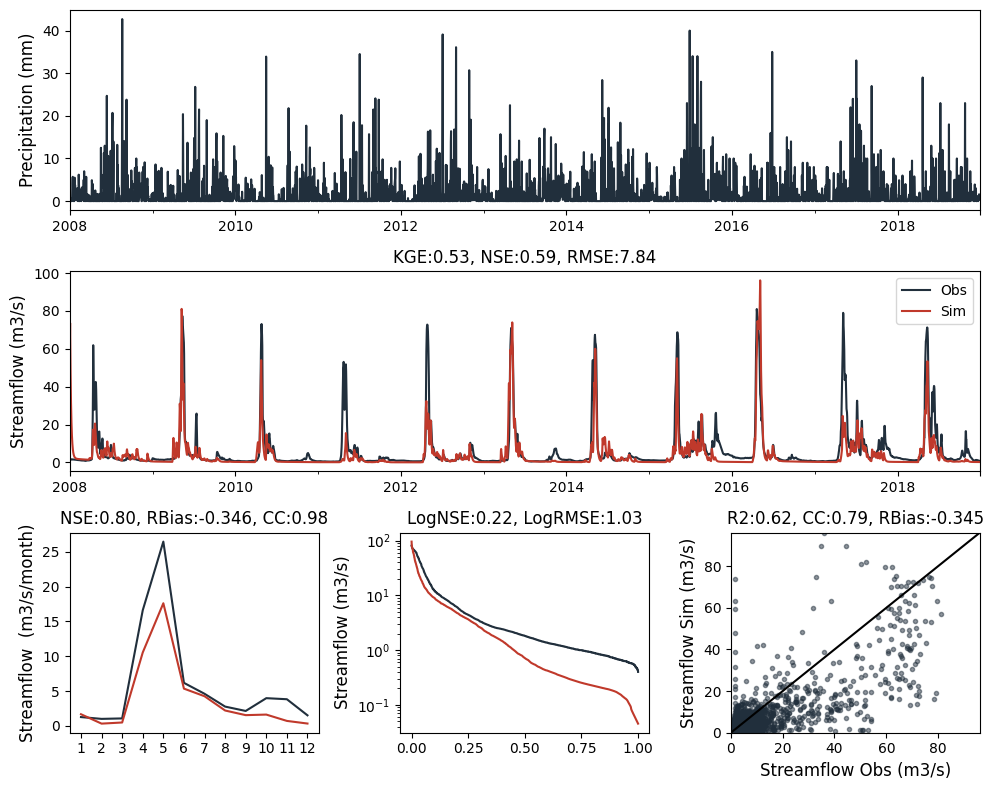




Validation period


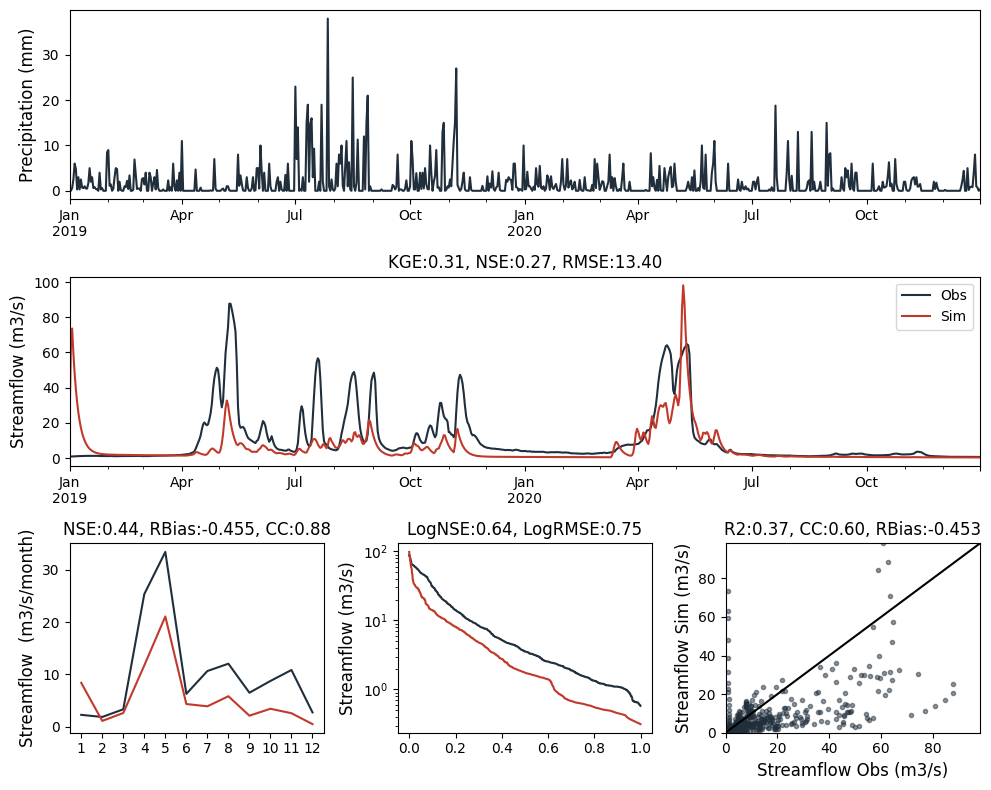

In [14]:
area = 830
lat = 58.5
x = parameters_test
metrics, sim_val, sim_cal = validation(hydro_data_df, "2008-01-01", "2018-12-31", "2019-01-01", "2020-12-31", area, lat, x)

In [15]:
metrics

,Calibration,Validation
cc,0.787827,0.604297
nse,0.591340,0.271713
lnse,-0.355395,0.026299
kge,0.527463,0.311114
r2,0.620672,0.365175
mae,3.394928,6.886721
rmse,7.842462,13.397649
bias,0.654952,0.546786
rbias,-0.345048,-0.453214


In [16]:
sim_cal['q_obs'] = hydro_data_df['qt']
sim_val['q_obs'] = hydro_data_df['qt']

In [17]:
sim_cal[['qt', 'q_obs']]

,qt,q_obs
date,,
2008-01-01,22.563679,1.65
2008-01-02,63.319786,1.65
2008-01-03,73.636147,1.65
2008-01-04,59.445038,1.65
2008-01-05,48.066395,1.65
...,...,...
2018-12-27,0.218322,0.87
2018-12-28,0.217243,0.84
2018-12-29,0.216170,0.86


In [18]:
sim_cal[['qt', 'q_obs']].to_excel("velva_sim.xlsx")

In [19]:
sim_val[['qt', 'q_obs']].to_excel("velva_val.xlsx")